In [1]:
!pip install qiskit-aer
!pip install qiskit-execute



ERROR: Could not find a version that satisfies the requirement qiskit-execute (from versions: none)
ERROR: No matching distribution found for qiskit-execute


In [4]:
!pip install qiskit-terra

In [313]:
from qiskit import QuantumCircuit
from qiskit.execute_function import execute


from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'qiskit.execute_function'

In [62]:

n_qubits = 4
qc = QuantumCircuit(n_qubits)

qc.x(0) 

qc.h(1)      
qc.x(2)     
qc.cx(0, 3) 


qc.measure_all()

print(qc)

#simulator = Aer.get_backend('qasm_simulator')
#result = execute(qc, backend=simulator, shots=1024).result()


#counts = result.get_counts()
#

        ┌───┐      ░ ┌─┐         
   q_0: ┤ X ├──■───░─┤M├─────────
        ├───┤  │   ░ └╥┘┌─┐      
   q_1: ┤ H ├──┼───░──╫─┤M├──────
        ├───┤  │   ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├──┼───░──╫──╫─┤M├───
        └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ─────┤ X ├─░──╫──╫──╫─┤M├
             └───┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════╩══╩══╩══╩═
                      0  1  2  3 


# Part 1 : Creating the lattice

the below lines of code help to set up the latice model for protien folding algorithms


In [2]:
from scipy.stats import norm


In [50]:
import random
#random.seed(42)
import numpy as np
import itertools
#np.random.seed(42)
import matplotlib.pyplot as plt

class BeadSystem:
    def __init__(self, N, bead_types):
        self.N = N
        self.bead_types = bead_types
        self.num_qubits = 6 * (N - 1)
        self.variables = self.initialize_variables()
        
    def initialize_variables(self):
    
        variables = {
            
            'xia': np.random.randint(0, 2, self.N-1),
            'xib': np.random.randint(0, 2, self.N-1),
            'yai': np.random.randint(0, 2, self.N-1),
            'ybi': np.random.randint(0, 2, self.N-1),
            'zai': np.random.randint(0, 2, self.N-1),
            'zbi': np.random.randint(0, 2, self.N-1)
        }
        return variables
    
    def calculate_turns(self):
        turns = []
        for i in range(self.N - 1):
            xit = self.variables['xia'][i] - self.variables['xib'][i]
            yti = self.variables['yai'][i] - self.variables['ybi'][i]
            zti = self.variables['zai'][i] - self.variables['zbi'][i]
            turns.append((xit, yti, zti))
        return turns

    def continuity_constraint(self, turns):
        C1 = 0
        for xit, yti, zti in turns:
            C1 += (1 - (xit**2) * (yti**2) * (zti**2)) + ((xit**2) * (yti**2)) + ((yti**2) * (zti**2)) + ((zti**2) * (xit**2))
        return C1

    def overlap_constraint(self, turns): # overlap and diagional criteria
        N = len(turns) + 1
        coordinates = [(0, 0, 0)]
        
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
        
        for i in range(N - 2):
            for j in range(i + 2, N):
                a, b, c = norm.rvs(size=3)  # Random numbers from a normal distribution
                
                if a > b and a > c:
                    alpha, beta, gamma = 1, 0, 0
                elif b > a and b > c:
                    alpha, beta, gamma = 0, 1, 0
                else:
                    alpha, beta, gamma = 0, 0, 1
                
                x_diff = coordinates[i][0] - coordinates[j][0]
                y_diff = coordinates[i][1] - coordinates[j][1]
                z_diff = coordinates[i][2] - coordinates[j][2]
                
                if alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2 == 0:
                    return False 

                if j + 1 < N:
                    x_rk = coordinates[j + 1][0] - coordinates[i + 1][0] + 2 * (coordinates[i][0] - coordinates[j][0])
                    y_rk = coordinates[j + 1][1] - coordinates[i + 1][1] + 2 * (coordinates[i][1] - coordinates[j][1])
                    z_rk = coordinates[j + 1][2] - coordinates[i + 1][2] + 2 * (coordinates[i][2] - coordinates[j][2])
    
                    if alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2 == 0:
                        return False
        
        return True  

    
    def possible_turns(self):
        return [
            (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0),
            (0, 0, 1), (0, 0, -1),
            (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0),
            (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1),
            (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1),
            (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1),
            (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)
        ]
    
    def generate_interaction_weights(self):
        interactions = []
        for i, j in itertools.combinations(range(self.N), 2):
            if self.bead_types[i] == 'H' and self.bead_types[j] == 'H':
                interactions.append((i, j))
        return interactions
    
    def calculate_coordinates(self):
        while True:
            turns = self.calculate_turns()
    
            # Check continuity and overlap constraints if they dont satisfy reintialise coordinates
            
            if self.continuity_constraint(turns) > 0 and self.overlap_constraint(turns):
                break
    
            self.variables = self.initialize_variables() 
    
        coordinates = [(0, 0, 0)]
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
    
        return coordinates



    def display(self):
        print("Number of beads:", self.N)
        print("Number of qubits needed:", self.num_qubits)
        print("Bead Types:", self.bead_types)
        print("Variables:")
        for key, value in self.variables.items():
            print(f"{key}: {value}")
        print("Possible turns:", self.possible_turns())
        

    
    def objectivefunction(self,coordinates):
        objective_value = 0.0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']

        weight = 1 # We can change 
        
        for i, j in itertools.combinations(H_indices, 2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            distance = np.linalg.norm(coord1 - coord2)
            temp_value = weight*distance # Euclidean distance
            objective_value += temp_value

        return objective_value     


    def combined_constraint(self):
        C1 = self.continuity_constraint(turns)
        return C1
            
        
        
        

N = 7  # Number of beads
bead_types = ['H', 'B', 'H', 'H','B',"B",'H']  # Example bead types sequence
bead_system = BeadSystem(N, bead_types)
bead_system.display()

# Calculate and display turns
turns = bead_system.calculate_turns()
print("Turns:", turns)

# Calculate and display bead coordinates
coordinates = bead_system.calculate_coordinates()
print("Coordinates:", coordinates)

# Generate interaction weights
interaction_weights = bead_system.generate_interaction_weights()
print("Interaction Weights (between 'H' beads only):", interaction_weights)


objective_value = bead_system.objectivefunction(coordinates)
print("The objective function which should be minimised is :",objective_value)

temp =bead_system.combined_constraint()
print(temp)


Number of beads: 7
Number of qubits needed: 36
Bead Types: ['H', 'B', 'H', 'H', 'B', 'B', 'H']
Variables:
xia: [0 0 0 1 0 0]
xib: [1 1 1 0 1 0]
yai: [0 0 1 0 1 1]
ybi: [1 0 0 0 1 0]
zai: [1 0 0 0 1 1]
zbi: [0 0 1 0 0 1]
Possible turns: [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1), (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0), (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1), (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1), (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1), (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)]
Turns: [(np.int64(-1), np.int64(-1), np.int64(1)), (np.int64(-1), np.int64(0), np.int64(0)), (np.int64(-1), np.int64(1), np.int64(-1)), (np.int64(1), np.int64(0), np.int64(0)), (np.int64(-1), np.int64(0), np.int64(1)), (np.int64(0), np.int64(1), np.int64(0))]
Coordinates: [(0, 0, 0), (np.int64(-1), np.int64(-1), np.int64(1)), (np.int64(-2), np.int64(0), np.int64(2)), (np.int64(-3), np.int64(0), np.int64(3)), (np.int64(-4), np.int64(1), np.int64(3

In [51]:
def ploting_points(coordinates):
    x,y,z = zip(*coordinates)
    for i in range(N):
        print(x[i],y[i],z[i])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='r', marker='o',s = 100)
    ax.plot(x, y, z, color='black')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

0 0 0
-1 -1 1
-2 0 2
-3 0 3
-4 1 3
-5 1 2
-4 1 2


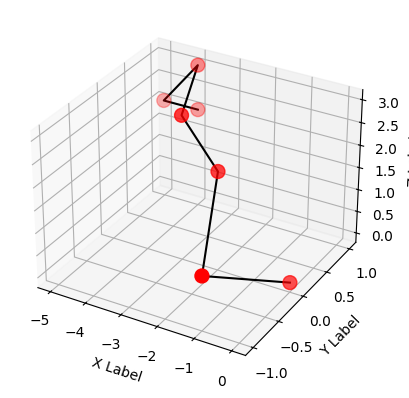

In [52]:
ploting_points(coordinates)

In [76]:
# list1 =[]
# for i in range(100):
#     bead_system = BeadSystem(N, bead_types)
#     bead_system.calculate_turns()
#     coordinates = bead_system.calculate_coordinates()
#     list1.append(coordinates)
    

In [81]:
# list1
# count = 0
# for lists in list1:
#     print(lists)
    
    

[(0, 0, 0), (-1, 0, 1), (0, 0, 0), (-1, -1, 0)]
[(0, 0, 0), (1, -1, 0), (1, -2, -1), (1, -1, -1)]
[(0, 0, 0), (0, 0, -1), (1, 0, -1), (1, 0, -1)]
[(0, 0, 0), (1, 0, 0), (1, -1, 1), (2, -1, 1)]
[(0, 0, 0), (1, 0, 0), (1, 0, 1), (1, 0, 1)]
[(0, 0, 0), (0, 0, 0), (-1, -1, 0), (-2, -1, 0)]
[(0, 0, 0), (0, 0, -1), (0, -1, -1), (1, -1, -2)]
[(0, 0, 0), (0, 1, -1), (0, 0, -1), (0, 0, 0)]
[(0, 0, 0), (-1, -1, 0), (-2, -1, 0), (-3, 0, -1)]
[(0, 0, 0), (0, -1, 0), (0, -2, 1), (0, -2, 2)]
[(0, 0, 0), (0, -1, 0), (0, -1, -1), (0, -2, -1)]
[(0, 0, 0), (0, 1, -1), (0, 0, 0), (0, 1, 0)]
[(0, 0, 0), (-1, 0, 0), (-1, 0, 0), (-1, 0, 1)]
[(0, 0, 0), (0, 0, -1), (-1, 0, -1), (-1, 0, -1)]
[(0, 0, 0), (1, -1, 1), (1, -1, 2), (0, -1, 1)]
[(0, 0, 0), (0, 0, 0), (-1, -1, -1), (-1, -1, -2)]
[(0, 0, 0), (-1, 1, -1), (-1, 0, -1), (0, 0, 0)]
[(0, 0, 0), (0, -1, 0), (0, 0, 1), (0, 0, 1)]
[(0, 0, 0), (0, 0, -1), (-1, 0, 0), (-2, -1, 0)]
[(0, 0, 0), (-1, 0, -1), (0, 0, -1), (1, 1, -1)]
[(0, 0, 0), (0, -1, 0), (0, -1,

## Qubo Problem

In [44]:
# overlap criteria is C2


# Qubo Prolem

In [12]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt



class BeadSystem:
    def __init__(self, N, bead_types):
        """
        Initialize the bead system.

        Parameters:
        - N: Number of beads
        - bead_types: List of bead types ('H' for hydrophobic, 'B' for non-hydrophobic)
        """
        self.N = N
        self.bead_types = bead_types
        self.num_qubits = 6 * (N - 1)
        self.variables = self.initialize_variables()
        self.lambda0 = random.randint(10,100)
        self.lambda1 = random.randint(10,100)
        self.lambda2 = random.randint(10,100)
        self.lambda3 = random.randint(10,100)
        
        
    def initialize_variables(self):
    
        variables = {
            
            'xia': np.random.randint(0, 2, self.N-1),
            'xib': np.random.randint(0, 2, self.N-1),
            'yai': np.random.randint(0, 2, self.N-1),
            'ybi': np.random.randint(0, 2, self.N-1),
            'zai': np.random.randint(0, 2, self.N-1),
            'zbi': np.random.randint(0, 2, self.N-1)
        }
        return variables
    
    def calculate_turns(self):
        turns = []
        for i in range(self.N - 1):
            xit = self.variables['xia'][i] - self.variables['xib'][i]
            yti = self.variables['yai'][i] - self.variables['ybi'][i]
            zti = self.variables['zai'][i] - self.variables['zbi'][i]
            turns.append((xit, yti, zti))
        return turns

    def continuity_constraint(self, turns):
        C1 = 0
        for xit, yti, zti in turns:
            C1 += (1 - (xit**2) - (yti**2) - (zti**2) )
        for i in range(self.N-1):
            C1 += self.variables['xia'][i]*self.variables['ybi'][i] + self.variables['xib'][i]*self.variables['yai'][i]+self.variables['yai'][i]*self.variables['zbi'][i] + self.variables['ybi'][i]*self.variables['zai'][i] + self.variables['zai'][i]*self.variables['xib'][i] + self.variables['zbi'][i]*self.variables['xia'][i]
                   
        return C1
        
    def constraint4(self,turns):
        C4= 0
        for i in range(self.N-1):
            C4 += self.variables['xia'][i]*self.variables['xib'][i] + self.variables['ybi'][i]*self.variables['yai'][i] + self.variables['zbi'][i]*self.variables['zai'][i]
        return C4 
        
    def overlap_constraint(self, turns): 
        N = len(turns) + 1
        coordinates = [(0, 0, 0)]
        
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
        
        for i in range(N - 2):
            for j in range(i + 2, N):

                a, b, c = norm.rvs(size=3)
                
                if a > b and a > c:
                    alpha, beta, gamma = 1, 0, 0
                elif b > a and b > c:
                    alpha, beta, gamma = 0, 1, 0
                else:
                    alpha, beta, gamma = 0, 0, 1
                    
                    
                x_diff = coordinates[i][0] - coordinates[j][0]
                y_diff = coordinates[i][1] - coordinates[j][1]
                z_diff = coordinates[i][2] - coordinates[j][2]
                
                distance =+ alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2
        
        return distance
    
    def diagonal_constraint(self, coordinates): 
        N = len(coordinates)
        total_diagonal_value
        
        for i in range(N - 2):
            for j in range(i + 2, N):
                a, b, c = norm.rvs(size=3)
                
                if a > b and a > c:
                    alpha, beta, gamma = 1, 0, 0
                elif b > a and b > c:
                    alpha, beta, gamma = 0, 1, 0
                else:
                    alpha, beta, gamma = 0, 0, 1
    
                x_diff = coordinates[i][0] - coordinates[j][0]
                y_diff = coordinates[i][1] - coordinates[j][1]
                z_diff = coordinates[i][2] - coordinates[j][2]
                
                diagonal_value = alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2
                total_diagonal_value +=diagonal_value
    

                if j + 1 < N:
                    x_rk = coordinates[j + 1][0] - coordinates[i + 1][0] + 2 * (coordinates[i][0] - coordinates[j][0])
                    y_rk = coordinates[j + 1][1] - coordinates[i + 1][1] + 2 * (coordinates[i][1] - coordinates[j][1])
                    z_rk = coordinates[j + 1][2] - coordinates[i + 1][2] + 2 * (coordinates[i][2] - coordinates[j][2])
        
                    diagonal_value_rk = alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2
                    if diagonal_value_rk == 0:
                        return diagonal_value_rk
        
        return diagonal_value
       


    
    def possible_turns(self):
        return [
            (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0),
            (0, 0, 1), (0, 0, -1),
            (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0),
            (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1),
            (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1),
            (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1),
            (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)
        ]
    
    def generate_interaction_weights(self):
        interactions = []
        for i, j in itertools.combinations(range(self.N), 2):
            if self.bead_types[i] == 'H' and self.bead_types[j] == 'H':
                interactions.append((i, j))
        return interactions
    
    def calculate_coordinates(self):
        #while True:
        turns = self.calculate_turns()
    
            # Check continuity and overlap constraints
            #if self.continuity_constraint(turns) > 0 and self.overlap_constraint(turns):
                #break
    
            #self.variables = self.initialize_variables()  # Re-initialize variables if constraints are not met
    
        coordinates = [(0, 0, 0)]
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
    
        return coordinates



    def display(self):
        print("Number of beads:", self.N)
        print("Number of qubits needed:", self.num_qubits)
        print("Bead Types:", self.bead_types)
        print("Variables:")
        for key, value in self.variables.items():
            print(f"{key}: {value}")
        print("Possible turns:", self.possible_turns())
    def objectivefunction(self,coordinates):
        objective_value = 0.0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']

        weight = 1 # can be changed depending on the model and the kind of interaction taking place
        
        for i, j in itertools.combinations(H_indices, 2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            distance = np.linalg.norm(coord1 - coord2)
            temp_value = weight*distance# Euclidean distance
            objective_value += distance

        return objective_value
    def energy_function(self, coordinates):

        total_energy = 0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
    
        # Iterate over all non-adjacent pairs of H beads
        for i, j in itertools.combinations(H_indices, 2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            
            # Calculate the squared Euclidean distance between the two H beads
            distance_squared = np.sum((coord1 - coord2)**2)
            
        
            if distance_squared == 1 or distance_squared == 2 or distance_squared == 3:
                total_energy -= 1  # Add -1 for each valid contact
    
        return total_energy
    
    def combined_constraint(self):
        C1 = self.continuity_constraint(turns)
        C2 = self.objectivefunction(coordinates)
        C4 = self.constraint4(turns)
        C3 = self.overlap_constraint(turns)
        C0 = self.diagonal_constraint(coordinates)
        
        
        
        return self.lambda0*C1 + self.lambda1*C2 + self.lambda2*C3 + self.lambda3*C4 +self.lambda0*C0
            
        
        
        

N = 6  # Number of beads
bead_types = ['H', 'B', 'H', 'H','B',"H"]  # Example bead types sequence
bead_system = BeadSystem(N, bead_types)
bead_system.display()

# Calculate and display turns
turns = bead_system.calculate_turns()
print("Turns:", turns)

continuity = bead_system.continuity_constraint(turns)
print(continuity)
# Calculate and display bead coordinates
coordinates = bead_system.calculate_coordinates()
print("Coordinates:", coordinates)

# Generate interaction weights
interaction_weights = bead_system.generate_interaction_weights()
print("Interaction Weights (between 'H' beads only):", interaction_weights)


objective_value = bead_system.objectivefunction(coordinates)
print("The objective function which should be minimised is :",objective_value)


#combined_constraint_value = 1

temp = bead_system.combined_constraint()
print(f'{temp} is the combined constraint value')
energy = bead_system.combined_constraint()
print(energy)


Number of beads: 6
Number of qubits needed: 30
Bead Types: ['H', 'B', 'H', 'H', 'B', 'H']
Variables:
xia: [0 1 0 1 1]
xib: [1 0 1 0 1]
yai: [1 0 1 0 1]
ybi: [0 1 0 0 1]
zai: [1 0 1 0 1]
zbi: [0 1 0 1 1]
Possible turns: [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1), (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0), (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1), (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1), (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1), (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)]
Turns: [(np.int64(-1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(0), np.int64(-1)), (np.int64(0), np.int64(0), np.int64(0))]
7
Coordinates: [(0, 0, 0), (np.int64(-1), np.int64(1), np.int64(1)), (np.int64(0), np.int64(0), np.int64(0)), (np.int64(-1), np.int64(1), np.int64(1)), (np.int64(0), np.int64(1), np.int64(0)), (np.int64(0), np.int64(1), np.int64(0))]
Interaction Wei

UnboundLocalError: local variable 'total_diagonal_value' referenced before assignment

0 0 0
-1 1 1
0 0 0
-1 1 1
0 1 0
0 1 0


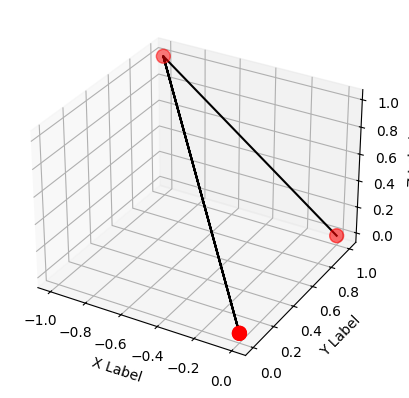

In [13]:
def ploting_points(coordinates):
    x,y,z = zip(*coordinates)
    for i in range(N):
        print(x[i],y[i],z[i])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='r', marker='o',s = 100)
    ax.plot(x, y, z, color='black')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
ploting_points(coordinates) 

## Final Solution

In [14]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from pyqubo import Binary, Constraint, solve_qubo

class BeadSystem:
    def __init__(self, N, bead_types):
        """
        Initialize the bead system.

        Parameters:
        - N: Number of beads
        - bead_types: List of bead types ('H' for hydrophobic, 'B' for non-hydrophobic)
        """
        self.N = N
        self.bead_types = bead_types
        self.num_qubits = 6 * (N - 1)
        self.variables = self.initialize_variables()
        self.lambda0 = random.randint(10, 100)
        self.lambda1 = random.randint(10, 100)
        self.lambda2 = random.randint(10, 100)
        self.lambda3 = random.randint(10, 100)
        
    def initialize_variables(self):
        num_vars = self.N - 1
    
        # Define binary variables using PyQUBO
        variables = {
            'xia': [Binary(f'xia_{i}') for i in range(num_vars)],
            'xib': [Binary(f'xib_{i}') for i in range(num_vars)],
            'yai': [Binary(f'yai_{i}') for i in range(num_vars)],
            'ybi': [Binary(f'ybi_{i}') for i in range(num_vars)],
            'zai': [Binary(f'zai_{i}') for i in range(num_vars)],
            'zbi': [Binary(f'zbi_{i}') for i in range(num_vars)]
        }
        return variables

    def calculate_turns(self):
        turns = []
        for i in range(self.N - 1):
            xit = self.variables['xia'][i] - self.variables['xib'][i]
            yti = self.variables['yai'][i] - self.variables['ybi'][i]
            zti = self.variables['zai'][i] - self.variables['zbi'][i]
            turns.append((xit, yti, zti))
        return turns

    def continuity_constraint(self):
        turns = self.calculate_turns()
        C1 = sum(1 - (xit**2 + yti**2 + zti**2) for xit, yti, zti in turns)
        for i in range(self.N - 1):
            C1 += (self.variables['xia'][i] * self.variables['ybi'][i] +
                   self.variables['xib'][i] * self.variables['yai'][i] +
                   self.variables['yai'][i] * self.variables['zbi'][i] +
                   self.variables['ybi'][i] * self.variables['zai'][i] +
                   self.variables['zai'][i] * self.variables['xib'][i] +
                   self.variables['zbi'][i] * self.variables['xia'][i])
        return C1

    def constraint4(self):
        C4 = sum(self.variables['xia'][i] * self.variables['xib'][i] +
                 self.variables['ybi'][i] * self.variables['yai'][i] +
                 self.variables['zbi'][i] * self.variables['zai'][i] for i in range(self.N - 1))
        return C4



    # def overlap_constraint(self):
    #     N = len(self.variables['xia']) + 1
    #     coordinates = [(0, 0, 0)]
    
    #     for i in range(N - 1):
    #         xit = self.variables['xia'][i] - self.variables['xib'][i]
    #         yti = self.variables['yai'][i] - self.variables['ybi'][i]
    #         zti = self.variables['zai'][i] - self.variables['zbi'][i]
    #         last_x, last_y, last_z = coordinates[-1]
    #         new_x = last_x + xit
    #         new_y = last_y + yti
    #         new_z = last_z + zti
    #         coordinates.append((new_x, new_y, new_z))
        
    #     overlap_penalty = 0
    #     for i in range(N - 2):
    #         for j in range(i + 2, N):
    #             x_diff = coordinates[i][0] - coordinates[j][0]
    #             y_diff = coordinates[i][1] - coordinates[j][1]
    #             z_diff = coordinates[i][2] - coordinates[j][2]
                
    #             distance_squared = x_diff**2 + y_diff**2 + z_diff**2
    #             # Add a penalty if distance_squared is very small
    #             overlap_penalty += (distance_squared - 1)**2  # Adjust penalty as needed
    
    #     return overlap_penalty

    # Overlap_penalty orginal
    

    def overlap_constraint(self, turns): # overlap and diagional criteria
        overlap_penalty = 0
        
        N = len(turns) + 1
        coordinates = [(0, 0, 0)]
        
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
        
        for i in range(N - 2):
            for j in range(i + 2, N):
                a, b, c = norm.rvs(size=3)  # Random numbers from a normal distribution
                
                if a > b and a > c:
                    alpha, beta, gamma = 1, 0, 0
                elif b > a and b > c:
                    alpha, beta, gamma = 0, 1, 0
                else:
                    alpha, beta, gamma = 0, 0, 1
                
                x_diff = coordinates[i][0] - coordinates[j][0]
                y_diff = coordinates[i][1] - coordinates[j][1]
                z_diff = coordinates[i][2] - coordinates[j][2]
                
                overlap_penality += alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2 
                   

                # if j + 1 < N:
                #     x_rk = coordinates[j + 1][0] - coordinates[i + 1][0] + 2 * (coordinates[i][0] - coordinates[j][0])
                #     y_rk = coordinates[j + 1][1] - coordinates[i + 1][1] + 2 * (coordinates[i][1] - coordinates[j][1])
                #     z_rk = coordinates[j + 1][2] - coordinates[i + 1][2] + 2 * (coordinates[i][2] - coordinates[j][2])
    
                #     if alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2 == 0:
                        
        
        return overlap_penality  

        def diagonal_constraint(self, turns):
            diagonal_penality = 0# overlap and diagional criteria
            N = len(turns) + 1
            coordinates = [(0, 0, 0)]
            
            for xit, yti, zti in turns:
                last_x, last_y, last_z = coordinates[-1]
                new_x = last_x + xit
                new_y = last_y + yti
                new_z = last_z + zti
                coordinates.append((new_x, new_y, new_z))
            
            for i in range(N - 2):
                for j in range(i + 2, N):
                    a, b, c = norm.rvs(size=3)  # Random numbers from a normal distribution
                    
                    if a > b and a > c:
                        alpha, beta, gamma = 1, 0, 0
                    elif b > a and b > c:
                        alpha, beta, gamma = 0, 1, 0
                    else:
                        alpha, beta, gamma = 0, 0, 1
                    
                    x_diff = coordinates[i][0] - coordinates[j][0]
                    y_diff = coordinates[i][1] - coordinates[j][1]
                    z_diff = coordinates[i][2] - coordinates[j][2]
                    
                    if alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2 == 0:
                        return False 
    
                    if j + 1 < N:
                        x_rk = coordinates[j + 1][0] - coordinates[i + 1][0] + 2 * (coordinates[i][0] - coordinates[j][0])
                        y_rk = coordinates[j + 1][1] - coordinates[i + 1][1] + 2 * (coordinates[i][1] - coordinates[j][1])
                        z_rk = coordinates[j + 1][2] - coordinates[i + 1][2] + 2 * (coordinates[i][2] - coordinates[j][2])
        
                        diagonal_penality =  alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2 
                            
            
            return diagonal_penality

    '''diagonal_constraint_criteria orginal'''
    # def diagonal_constraint(self):
    #     coordinates = self.calculate_coordinates()
    #     N = len(coordinates)
    #     diagonal_penalty = 0
    
    #     for i in range(N - 2):
    #         for j in range(i + 2, N):
    #             a, b, c = np.random.normal(size=3)
                
    #             if a > b and a > c:
    #                 alpha, beta, gamma = 1, 0, 0
    #             elif b > a and b > c:
    #                 alpha, beta, gamma = 0, 1, 0
    #             else:
    #                 alpha, beta, gamma = 0, 0, 1
    
    #             x_diff = coordinates[i][0] - coordinates[j][0]
    #             y_diff = coordinates[i][1] - coordinates[j][1]
    #             z_diff = coordinates[i][2] - coordinates[j][2]
    
    #             diagonal_value = alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2
                
    #             # Add a penalty if diagonal_value is not zero
    #             diagonal_penalty += diagonal_value**2  # Penalize large diagonal values
    
    #             if j + 1 < N:
    #                 x_rk = coordinates[j + 1][0] - coordinates[i + 1][0] + 2 * (coordinates[i][0] - coordinates[j][0])
    #                 y_rk = coordinates[j + 1][1] - coordinates[i + 1][1] + 2 * (coordinates[i][1] - coordinates[j][1])
    #                 z_rk = coordinates[j + 1][2] - coordinates[i + 1][2] + 2 * (coordinates[i][2] - coordinates[j][2])
                    
    #                 diagonal_value_rk = alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2
    #                 diagonal_penalty += diagonal_value_rk**2  # Penalize large diagonal values
    
    #     return diagonal_penalty
    

    def possible_turns(self):
        return [
            (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0),
            (0, 0, 1), (0, 0, -1),
            (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0),
            (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1),
            (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1),
            (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1),
            (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)
        ]
    
    def generate_interaction_weights(self):
        interactions = []
        for i, j in itertools.combinations(range(self.N), 2):
            if self.bead_types[i] == 'H' and self.bead_types[j] == 'H':
                interactions.append((i, j))
        return interactions
    
    def calculate_coordinates(self):
        turns = self.calculate_turns()
    
        coordinates = [(0, 0, 0)]
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
    
        return coordinates

    def display(self):
        print("Number of beads:", self.N)
        print("Number of qubits needed:", self.num_qubits)
        print("Bead Types:", self.bead_types)
        print("Variables:")
        for key, value in self.variables.items():
            print(f"{key}: {value}")
        print("Possible turns:", self.possible_turns())
    
    def objectivefunction(self):
        coordinates = self.calculate_coordinates()
        objective_value = 0.0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
        weight = 1 # can be changed depending on the model and the kind of interaction taking place
        
        for i, j in itertools.combinations(H_indices, 2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            distance = np.sum((coord1 - coord2)**2)
            objective_value += weight * distance  # Objective function to minimize distance

        return objective_value

    def energy_function(self):
        coordinates = self.calculate_coordinates()
        total_energy = 0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
    
        # Iterate over all non-adjacent pairs of H beads
        for i, j in itertools.combinations(H_indices, 2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            distance_squared = np.sum((coord1 - coord2)**2)
        
            if distance_squared in [1, 2, 3]:
                total_energy -= 1  # Add -1 for each valid contact
    
        return total_energy

    def combined_constraint(self):
        turns = self.calculate_turns()
        coordinates = self.calculate_coordinates()
        
        C1 = self.continuity_constraint()
        C2 = self.objectivefunction()
        C4 = self.constraint4()
        C3 = self.overlap_constraint()
        C0 = self.diagonal_constraint()
        
        return self.lambda0*C1 + self.lambda1*C2 + self.lambda2*C3 + self.lambda3*C4 + self.lambda0*C0

    def make_qubo(self):
    # Construct the QUBO expression
        qubo_expr =  self.lambda0 * self.continuity_constraint() + self.lambda1 * self.objectivefunction() + self.lambda2 * self.overlap_constraint() + self.lambda3 * self.constraint4() + self.lambda0 * self.diagonal_constraint()
        
        # Return the QUBO expression
        return qubo_expr
    def compile_qubo(self):
        # Get the QUBO expression
        qubo_expr = self.make_qubo()
        
        # Compile the QUBO expression into a QUBO model
        qubo_model = qubo_expr.compile()
        
        # Extract the QUBO dictionary
        qubo_dict = qubo_model.to_qubo()
        qubo_dict = qubo_dict[0]

        
        return qubo_dict
        
    def qubo_dict_to_matrix(self,qubo_dict):
    
        # Extract all unique variables from the keys
        variables = set()
        for key in qubo_dict.keys():
            var1, var2 = key  # Each key is a tuple of strings
            variables.add(var1)
            variables.add(var2)
        
        # Create a mapping from variable names to indices
        var_map = {var: idx for idx, var in enumerate(variables)}
        
        # Step 3: Initialize a zero matrix of appropriate size
        num_vars = len(variables)
        qubo_matrix = np.zeros((num_vars, num_vars))
        
        # Populate the matrix with the values from qubo_dict
        for (var1, var2), value in qubo_dict.items():
            i, j = var_map[var1], var_map[var2]
            qubo_matrix[i, j] = value
            # Assuming the QUBO matrix is symmetric
            if i != j:
                qubo_matrix[j, i] = value
        
        return qubo_matrix, var_map


# Example Usage
N = 4  # Number of beads
bead_types = ['H', 'B','H','H']  # Example bead types sequence
bead_system = BeadSystem(N, bead_types)
#bead_system.display()

# Calculate and display turns
turns = bead_system.calculate_turns()
#print("Turns:", turns)

# Calculate and display bead coordinates
coordinates = bead_system.calculate_coordinates()
#print(coordinates)
#print("Coordinates:", coordinates)

# Generate interaction weights
interaction_weights = bead_system.generate_interaction_weights()
#print("Interaction Weights (between 'H' beads only):", interaction_weights)

# Calculate objective function
objective_value = bead_system.objectivefunction()
#print("The objective function value is:", objective_value)

# Calculate combined constraint
combined_constraint_value = bead_system.combined_constraint()
#print(f'{combined_constraint_value} is the combined constraint value')

# Convert to QUBO format
qubo_dict = bead_system.compile_qubo()
print(qubo_dict)

#print(qubo_dict)
qubo,var_map = bead_system.qubo_dict_to_matrix(qubo_dict)
print("QUBO:", qubo)

TypeError: overlap_constraint() missing 1 required positional argument: 'turns'

In [99]:
!pip install dwave-neal



python(81443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached dwave_neal-0.6.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached dwave_samplers-1.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.8 kB)
Using cached dwave_neal-0.6.0-py3-none-any.whl (8.7 kB)
Using cached dwave_samplers-1.3.0-cp312-cp312-macosx_11_0_arm64.whl (1.9 MB)


In [54]:
# sampler = SimulatedAnnealingSampler()
# sampleset = sampler.sample_qubo(qubo_dict, num_reads=100)

# # Step 2: Extract the best solution (lowest energy)
# best_sample = sampleset.first.sample
# best_energy = sampleset.first.energy

# print(f"Best solution: {best_sample}")
# print(f"Best energy: {best_energy}")


## Decoding and plotting

In [18]:
!pip install qiskit-optimization

In [8]:
!brew install cmake

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:e7340e4a1d7cc0f113686e461b93114270848cb14676e9037a1a2ff3b1a0ff32
######################################################################### 100.0%     25.4%                                      30.1%    51.4%
==> Pouring portable-ruby-3.3.5.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 3 taps (brewsci/bio, homebrew/core and homebrew/cask).
==> New Formulae
action-docs                hawkeye                    polkit
afl++                      icu4c@74                   postgresql@17
aicommit                   icu4c@75                   probe-rs-tools
ansible-builder            icu4c@76                   python-freethreading
argtable3                  inchi                      python-gdbm@3.13
bin

In [38]:
pip install qiskit-optimization

  Using cached qiskit_optimization-0.6.1-py3-none-any.whl.metadata (8.6 kB)
  Using cached docplex-2.28.240.tar.gz (643 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Using cached qiskit_optimization-0.6.1-py3-none-any.whl (167 kB)
  Created wheel for docplex: filename=docplex-2.28.240-py3-none-any.whl size=682834 sha256=99625b8cd8592b38a555d08ff8da09485abf10285400946ec111345af68f861f
  Stored in directory: /Users/karthikrajesh/Library/Caches/pip/wheels/58/ef/1f/40e232b9489d004c808adbfdc81094dfd877458a7e9476f256
Successfully built docplex
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pyqubo

  Using cached pyqubo-1.0.8.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [73 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.1-arm64-cpython-312
      creating build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      copying pyqubo/package_info.py -> build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      copying pyqubo/__init__.py -> build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      copying pyqubo/logic.py -> build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      copying pyqubo/logical_constraint.py -> build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      copying pyqubo/array.py -> build/lib.macosx-11.1-arm64-cpython-312/pyqubo
      crea

In [269]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from pyqubo import Binary, Constraint, solve_qubo
import neal
from neal import SimulatedAnnealingSampler
from pyqubo import solve_qubo
from scipy.stats import norm
from qiskit_optimization import QuadraticProgram


class BeadSystem:
    def __init__(self, N, bead_types):
        self.N = N
        self.bead_types = bead_types
        self.num_qubits = 6 * (N - 1)
        self.variables = self.initialize_variables()
        self.lambda0 = 100 #continuity
        self.lambda1 = 100 # objective
        self.lambda2 = -1 # overlap
        self.lambda3 = 1000# 4th constraint
        self.lambda4 = -10 #diagonal
    def initialize_variables(self):
        num_vars = self.N - 1
    
        # Defining binary variables using PyQUBO Binary option
        variables = {
            'xia': [Binary(f'xia_{i}') for i in range(0,num_vars)],
            'xib': [Binary(f'xib_{i}') for i in range(0,num_vars)],
            'yai': [Binary(f'yai_{i}') for i in range(0,num_vars)],
            'ybi': [Binary(f'ybi_{i}') for i in range(0,num_vars)],
            'zai': [Binary(f'zai_{i}') for i in range(0,num_vars)],
            'zbi': [Binary(f'zbi_{i}') for i in range(0,num_vars)]
        }
        return variables

    def calculate_turns(self):
        turns = [] # Storing the turns here
        for i in range(self.N - 1):# Runing for loop N-1 times for N-1 turns
            xit = self.variables['xia'][i] - self.variables['xib'][i]# Calculating the turns(X)
            yti = self.variables['yai'][i] - self.variables['ybi'][i]# Calculating the turns(Y)
            zti = self.variables['zai'][i] - self.variables['zbi'][i]# Calculating the turns(Z)
            turns.append((xit, yti, zti))#Appending to the list
        return turns

    def continuity_constraint(self):
        turns = self.calculate_turns()#Calculation of the turns
        C1 = sum(1 - (xit**2 + yti**2 + zti**2) for xit, yti, zti in turns)# the first 4 terms
        for i in range(self.N - 1):
            C1 += (self.variables['xia'][i] * self.variables['ybi'][i] +
                   self.variables['xib'][i] * self.variables['yai'][i] +
                   self.variables['yai'][i] * self.variables['zbi'][i] +
                   self.variables['ybi'][i] * self.variables['zai'][i] +
                   self.variables['zai'][i] * self.variables['xib'][i] +
                   self.variables['zbi'][i] * self.variables['xia'][i])
        return C1

    def constraint4(self):
        C4 = sum(self.variables['xia'][i] * self.variables['xib'][i] +
                 self.variables['ybi'][i] * self.variables['yai'][i] +
                 self.variables['zbi'][i] * self.variables['zai'][i] for i in range(self.N - 1))
        return C4


    
    def overlap_constraint(self, turns): 
        overlap_penality = 0
        
        N = len(turns) + 1
        coordinates = [(0, 0, 0)]
        
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
        
        for i in range(0,N - 1):
            for j in range(i + 1, N-1):#i+2,N
                a, b, c = norm.rvs(size=3)  # Random numbers from a normal distribution
                
                if a > b and a > c:
                    alpha, beta, gamma = 1, 0, 0
                elif b > a and b > c:
                    alpha, beta, gamma = 0, 1, 0
                else:
                    alpha, beta, gamma = 0, 0, 1
                
                x_diff = coordinates[i][0] - coordinates[j][0]
                y_diff = coordinates[i][1] - coordinates[j][1]
                z_diff = coordinates[i][2] - coordinates[j][2]
                
                overlap_penality += alpha * x_diff**2 + beta * y_diff**2 + gamma * z_diff**2               
        
        return overlap_penality  

    def diagonal_constraint(self, turns):
            xt=[]
            yt=[]
            zt=[]
            for xit,yti,zti in turns:
                xt.append(xit)
                yt.append(yti)
                zt.append(zti)
            diagonal_penality = 0
            N = len(turns) + 1
            coordinates = [(0, 0, 0)]
            
            for xit, yti, zti in turns:
                last_x, last_y, last_z = coordinates[-1]
                new_x = last_x + xit
                new_y = last_y + yti
                new_z = last_z + zti
                coordinates.append((new_x, new_y, new_z))
            
            for r in range(0,N - 3):
                for k in range(r + 1, N-1):
                    a, b, c = norm.rvs(size=3) 
                    
                    if a > b and a > c:
                        alpha, beta, gamma = 1, 0, 0
                    elif b > a and b > c:
                        alpha, beta, gamma = 0, 1, 0
                    else:
                        alpha, beta, gamma = 0, 0, 1  
                    xr,yr,zr,xk,yk,zk = xt[r],yt[r],zt[r],xt[k],yt[k],zt[k]
                    x_rk = xr+xk
                    y_rk = yr+yk
                    z_rk = zr+zk
                    for j in range(r+1,k):
                        x_rk += 2*xt[j]
                        y_rk += 2*yt[j]
                        z_rk += 2*zt[j]        
                    diagonal_penality +=  alpha * x_rk**2 + beta * y_rk**2 + gamma * z_rk**2                
            
            return diagonal_penality

    def possible_turns(self):
        return [
            (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0),
            (0, 0, 1), (0, 0, -1),
            (1, 1, 0), (-1, 1, 0), (-1, -1, 0), (1, -1, 0),
            (0, 1, 1), (0, -1, 1), (0, -1, -1), (0, 1, -1),
            (1, 0, 1), (-1, 0, 1), (-1, 0, -1), (1, 0, -1),
            (1, 1, 1), (-1, 1, 1), (-1, -1, 1), (1, -1, 1),
            (1, 1, -1), (-1, 1, -1), (-1, -1, -1), (1, -1, -1)
        ]
    
    def generate_interaction_weights(self):
        # To Ensure the bead_types has the correct length same as that of N
        if len(self.bead_types) != self.N:
            raise ValueError(f"Length of bead_types is not equal to N")
    
        interactions = []
        for i, j in itertools.combinations(range(self.N), 2):
            if self.bead_types[i] == 'H' and self.bead_types[j] == 'H':
                interactions.append((i, j))
        return interactions

    
    def calculate_coordinates(self):
        turns = self.calculate_turns() #To Calculate the turns 
    
        coordinates = [(0, 0, 0)]  # First coordinate is set to (0,0,0)
        for xit, yti, zti in turns:
            lastx, lasty, lastz = coordinates[-1]
            newx = lastx + xit
            newy = lasty + yti
            newz = lastz + zti
            coordinates.append((newx, newy, newz))
    
        return coordinates

    def display(self):
        print("Number of beads:", self.N)
        print("Number of qubits needed:", self.num_qubits)
        print("Bead Types:", self.bead_types)
        print("Variables:")
        for key, value in self.variables.items():
            print(f"{key}: {value}")
        print("Possible turns:", self.possible_turns())
    
    # def objectivefunction(self):
    #     coordinates = self.calculate_coordinates()
    #     objective_value = 0.0
    #     H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
    #     weight = 1 # can be changed depending on the model and the kind of interaction taking place
        
    #     for i, j in itertools.combinations(H_indices, 2):
    #         coord1 = np.array(coordinates[i])
    #         coord2 = np.array(coordinates[j])
    #         distance = np.sum((coord1 - coord2)**2)
    #         objective_value += weight * distance  # Objective function to minimize distance

    #     return objective_value
        
    def objectivefunction(self):
        coordinates = self.calculate_coordinates()
        objective_value = 0.0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
        weight = 1  # Can be changed depending on the model and the kind of interaction
        
        # Calculate turns
        turns = self.calculate_turns()
        
        for j, k in itertools.combinations(H_indices, 2): # Running the loop over the H indices
            x_turn_sum = 0
            y_turn_sum = 0
            z_turn_sum = 0
            
            # Summing the turns for the given range (from j to k-1)
            for l in range(j, k): # Inner Sum
                x_turn_sum += turns[l][0]  # x_t^l
                y_turn_sum += turns[l][1]  # y_t^l
                z_turn_sum += turns[l][2]  # z_t^l
            
            # Objective function summing the squared turns along x, y, z axes
            objective_value += weight * (x_turn_sum**2 + y_turn_sum**2 + z_turn_sum**2)
        
        return objective_value


    def energy_function(self):
        coordinates = self.calculate_coordinates()
        total_energy = 0
        H_indices = [i for i, bead_type in enumerate(self.bead_types) if bead_type == 'H']
    
        # Iterate over all non-adja cent pairs of H beads
        for i, j in itertools.combinations(H_indices,2):
            coord1 = np.array(coordinates[i])
            coord2 = np.array(coordinates[j])
            distance_squared = np.sum((coord1 - coord2)**2)
        
            if distance_squared in [1, 2, 3]:
                total_energy -= 1  # Add -1 for each valid contact
    
        return total_energy

    def combined_constraint(self):
        turns = self.calculate_turns()
        coordinates = self.calculate_coordinates()
        
        C1 = self.continuity_constraint()
        C2 = self.objectivefunction()
        C4 = self.constraint4()
        C3 = self.overlap_constraint(turns)
        C0 = self.diagonal_constraint(turns)
        
        return self.lambda0*C1 + self.lambda1*C2 + self.lambda2*C3 + self.lambda3*C4 + self.lambda4*C0

    def make_qubo(self):
    
        qubo_expr =  self.lambda0 * self.continuity_constraint() + self.lambda1 * self.objectivefunction() + self.lambda2 * self.overlap_constraint(turns) + self.lambda3 * self.constraint4() + self.lambda4 * self.diagonal_constraint(turns)
        

        return qubo_expr
    def compile_qubo(self):

        qubo_expr = self.make_qubo()

        qubo_model = qubo_expr.compile()
        
        qubo_dict = qubo_model.to_qubo()
        qubo_dict = qubo_dict[0]

        bqm = qubo_model.to_bqm()
        

        
        return qubo_dict,bqm,qubo_model
        
    def Hamiltonian(self):
            H = self.make_qubo() #Gives the combined constraint
            model = H.compile() #Converts the QUBO into a processable form for optimisation
            qubo = model.to_qubo() #Converts into the matrix form
            qubo = qubo[0]
            ising = model.to_ising() # converts Qubo into an ising model
            linear, quadratic = [ising[i] for i in range(2)]
            filtered_terms = {k: v for k, v in qubo.items() if k[0] != k[1]}
            linear_terms = {k: v for k, v in qubo.items() if k[0] == k[1]}
            # print(filtered_terms)
            # print(linear_terms)
            
            indexed_data = {}
            index_counter = 0
            
            for key in sorted(linear_terms.keys()):
                indexed_data[key] = index_counter
                index_counter += 1
            
            # print(indexed_data)
            
            indexed_linear = {}
            for key, value in linear_terms.items():
                index_key = indexed_data[key]
                indexed_linear[index_key] = value
            
            # print(indexed_linear)
            
            final_linear = [value for key, value in sorted(indexed_linear.items(), key=lambda item: item[0])]
            # print(final_linear)
            
            values = sorted(linear.keys())
            
            qp = QuadraticProgram()# Intialize a quadratic program for Quantum Analysis down
            for value in values:
                qp.binary_var(name=value)# Setting up the variables in the QP

            qp.minimize(linear=final_linear, quadratic=filtered_terms)# QP is set to minimize the objective function
            # print(qp.prettyprint())

            op, offset = qp.to_ising()
            return op,offset

        
    def qubo_dict_to_matrix(self,qubo_dict):
    
        # Step 1: Extract all unique variables from the keys
        variables = set()
        for key in qubo_dict.keys():
            var1, var2 = key  # Each key is a tuple of strings
            variables.add(var1)
            variables.add(var2)
        
        # Step 2: Create a mapping from variable names to indices
        var_map = {var: idx for idx, var in enumerate(variables)}
        
        # Step 3: Initialize a zero matrix of appropriate size
        num_vars = len(variables)
        qubo_matrix = np.zeros((num_vars, num_vars))
        
        # Step 4: Populate the matrix with the values from qubo_dict
        for (var1, var2), value in qubo_dict.items():
            i, j = var_map[var1], var_map[var2]
            qubo_matrix[i, j] = value
            # Assuming the QUBO matrix is symmetric
            if i != j:
                qubo_matrix[j, i] = value
        
        return qubo_matrix, var_map

## The decoder

The below cells I have implemented the decoder

In [270]:
import numpy as np
import itertools

class BeadSystem2:
    def __init__(self, N, bead_types, variables):
        self.N = N
        self.bead_types = bead_types
        self.num_qubits = 6 * (N - 1)
        self.variables = variables 
        self.lambda0 = 10
        self.lambda1 = 20
        self.lambda2 = 30
        self.lambda3 = 40
        
    def calculate_turns(self):
     
        turns = []
        for i in range(self.N - 1):
            xit = self.variables['xia'][i] - self.variables['xib'][i]
            yti = self.variables['yai'][i] - self.variables['ybi'][i]
            zti = self.variables['zai'][i] - self.variables['zbi'][i]
            turns.append((xit, yti, zti))
        return turns

    def calculate_coordinates(self):
   
        turns = self.calculate_turns()
        coordinates = [(0, 0, 0)]  
        
        for xit, yti, zti in turns:
            last_x, last_y, last_z = coordinates[-1]
            new_x = last_x + xit
            new_y = last_y + yti
            new_z = last_z + zti
            coordinates.append((new_x, new_y, new_z))
        
        return coordinates
    
    def display(self):
      
        print("Number of beads:", self.N)
        print("Number of qubits needed:", self.num_qubits)
        print("Bead Types:", self.bead_types)
        print("Variables:")
        for key, value in self.variables.items():
            print(f"{key}: {value}")
        turns = self.calculate_turns()
        print("Turns:", turns)

# Example bead types sequence

# bead_system = BeadSystem(N, bead_types, variables)

# # Display system details and calculate coordinates
# bead_system.display()
# coordinates = bead_system.calculate_coordinates()
# print("Coordinates:", coordinates)

In [176]:
def ploting_points(coordinates, bead_types):
    x, y, z = zip(*coordinates)
    
    #for i in range(len(coordinates)):
        #print(x[i], y[i], z[i])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with colors depending on the bead type
    for i in range(len(coordinates)):
        color = 'blue' if bead_types[i] == 'H' else 'red'
        ax.scatter(x[i], y[i], z[i], c=color, marker='o', s=100)
    
    # Connect the points with a line
    ax.set(xlim=(-2, 3), xticks=np.arange(-2, 3),
       ylim=(-2, 3), yticks=np.arange(-2, 3),
        zlim =(-2,3), zticks = np.arange(-2,3))

    ax.plot(x, y, z, color='black')
    
    # Label the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

#ploting_points(coordinates, bead_types)


In [177]:

#print(calculate_overlap(coordinates))  

# Quantifying Hydrophobic collapse

In [178]:
def count_contacts(coords, bead_types):
    num_beads = len(coords)
    contacts = 0

    for i in range(num_beads):
        if bead_types[i] != 'H':
            continue 
        
        for j in range(i+1,num_beads):
            if bead_types[j] != 'H':
                continue
            
            distance = np.sum(np.abs(np.array(coords[i]) - np.array(coords[j])))
            
            if distance < 1.7329 and abs(i - j) > 1:
                contacts += 1

    return contacts
    

In [179]:
def calculate_overlap(coordinates):
    coordinates_unique = []
    count = 0
    
    for i in coordinates:
        if i in coordinates_unique:
            count +=1

        else:
            coordinates_unique.append(i)
            
    return count

# Post Processing 

In [182]:
def post_processing(coordinates):
    
    def is_present(coord, coord_list):
        return coord in coord_list
    
    def calculate_distance(coord1, coord2):
        return sum(abs(coord1[i] - coord2[i]) for i in range(3))
    
    def adjust_coordinate(curr, prev_coord, next_coord, coord_list):
        possible_shifts = [
            (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), 
            (0, 0, 1), (0, 0, -1), (1, 1, 0), (1, -1, 0), 
            (-1, 1, 0), (-1, -1, 0), (1, 0, 1), (1, 0, -1), 
            (-1, 0, 1), (-1, 0, -1), (0, 1, 1), (0, 1, -1), 
            (0, -1, 1), (0, -1, -1), (1, 1, 1), (1, 1, -1), 
            (1, -1, 1), (1, -1, -1), (-1, 1, 1), (-1, 1, -1), 
            (-1, -1, 1), (-1, -1, -1)
        ]
        
        min_total_distance = float('inf')
        best_coord = curr
        
        for shift in possible_shifts:
            new_coord = (curr[0] + shift[0], curr[1] + shift[1], curr[2] + shift[2])
            if not is_present(new_coord, coord_list):
                total_distance = (
                    calculate_distance(prev_coord, new_coord) + 
                    calculate_distance(new_coord, next_coord)
                )
                if total_distance < min_total_distance:
                    min_total_distance = total_distance
                    best_coord = new_coord
        
        return best_coord
    
    def adjust_overlaps(coords):
        coord_set = set(coords) 
        for i in range(len(coords)):
            if coords.count(coords[i]) > 1:
            
                prev_coord = coords[i - 1] if i > 0 else coords[i]  
                next_coord = None
                
                for j in range(i + 1, len(coords)):
                    if coords[j] != coords[i]:
                        next_coord = coords[j]
                        break
                
                if next_coord is None:  
                    next_coord = coords[i] 
                
                new_coord = adjust_coordinate(coords[i], prev_coord, next_coord, coord_set)
                
            
                coords[i] = new_coord     
    
    adjust_overlaps(coordinates)
    adjust_overlaps(coordinates)

    for i in range(len(coordinates)):
        while coordinates.count(coordinates[i]) > 1:
            prev_coord = coordinates[i - 1] if i > 0 else coordinates[i]
            next_coord = None
            
            for j in range(i + 1, len(coordinates)):
                if coordinates[j] != coordinates[i]:
                    next_coord = coordinates[j]
                    break
            
            if next_coord is None:
                next_coord = coordinates[i]

            new_coord = adjust_coordinate(coordinates[i], prev_coord, next_coord, coordinates)
            coord_set = set(coordinates)  
            while is_present(new_coord, coord_set):
                new_coord = adjust_coordinate(new_coord, prev_coord, next_coord, coord_set)
            coordinates[i] = new_coord  # Update the coordinate

    return coordinates



# Testing multiple and quantifying 

The qubo in dictionary format is {('yai_1', 'ybi_1'): 1002.0, ('ybi_1', 'yai_0'): -200.0, ('zai_2', 'xib_2'): 100.0, ('xia_2', 'xia_2'): -10.0, ('zbi_1', 'zbi_0'): 200.0, ('zai_1', 'zbi_2'): -200.0, ('zai_0', 'zai_0'): -1.0, ('xia_1', 'xia_2'): 160.0, ('xib_2', 'xib_0'): 180.0, ('xia_1', 'ybi_1'): 100.0, ('yai_1', 'ybi_0'): -200.0, ('zbi_0', 'xia_0'): 100.0, ('ybi_1', 'yai_2'): -200.0, ('zbi_1', 'zai_2'): -200.0, ('zai_2', 'zbi_0'): -200.0, ('zbi_1', 'yai_1'): 100.0, ('yai_0', 'ybi_0'): 1000.0, ('zbi_2', 'yai_2'): 100.0, ('ybi_1', 'ybi_0'): 200.0, ('xib_1', 'xia_0'): -138.0, ('ybi_1', 'ybi_2'): 200.0, ('xib_2', 'xib_2'): -10.0, ('xib_1', 'xib_1'): -51.0, ('zbi_0', 'yai_0'): 100.0, ('zai_0', 'zbi_0'): 1002.0, ('zbi_2', 'zbi_0'): 200.0, ('yai_2', 'yai_0'): 200.0, ('xib_0', 'yai_0'): 100.0, ('xia_0', 'xib_0'): 1042.0, ('xib_2', 'xia_0'): -180.0, ('yai_1', 'yai_2'): 200.0, ('xia_2', 'xib_0'): -180.0, ('xia_1', 'xib_2'): -160.0, ('yai_2', 'ybi_2'): 1000.0, ('zai_2', 'zai_0'): 200.0, ('xib_2

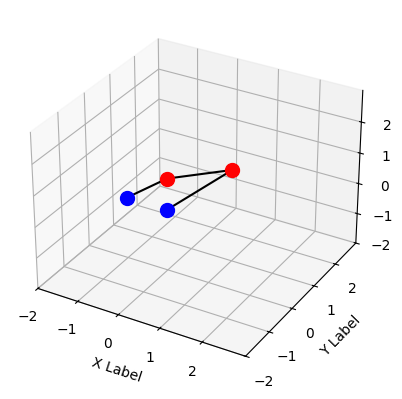

The number of overlaps is 0
The number of contacts is 1


In [276]:
from pprint import *



for i in range(1,2):
    N = 4  # Number of beads
    bead_seq = "HPPH"
    bead_types = list(bead_seq)
    bead_system = BeadSystem(N, bead_types)
    #bead_system.dispslay()
    
    turns = bead_system.calculate_turns()
    #print("Turns:", turns)
    
    coordinates = bead_system.calculate_coordinates()
    #print("Coordinates:", coordinates)

    interaction_weights = bead_system.generate_interaction_weights()
    #print("Interaction Weights (between 'H' beads only):", interaction_weights)

    
    objective_value = bead_system.objectivefunction()
    
    combined_constraint_value = bead_system.combined_constraint()
    #print(f'The combined constraint value in the Qubo format is given by {combined_constraint_value}')

    
    qubo_dict,bqm,qubo_model = bead_system.compile_qubo()
    
    #print(f'The qubo in dictionary format is {qubo_dict}')
    
    #print(bqm)
    qubo,var_map = bead_system.qubo_dict_to_matrix(qubo_dict)

    op,offset = bead_system.Hamiltonian()

    #print(op)
    #print(offset)

    #print("QUBO:", qubo)
    
    sa = neal.SimulatedAnnealingSampler()
    sampleset = sa.sample(bqm, num_reads=1000)
    samples = qubo_model.decode_sampleset(sampleset)
    best_sample = min(samples, key=lambda s: s.energy)
    data = best_sample.sample
    
    #pprint(data)
    
    variables = {
        'xia': [],
        'xib': [],
        'yai': [],
        'ybi': [],
        'zai': [],
        'zbi': []
    }
    xia_list = [f"xia_{i}" for i in range(16)]
    xib_list = [f"xib_{i}" for i in range(16)]
    yai_list = [f"yai_{i}" for i in range(16)]
    ybi_list = [f"ybi_{i}" for i in range(16)]
    zai_list = [f"zai_{i}" for i in range(16)]
    zbi_list = [f"zbi_{i}" for i in range(16)]
    
    for i in data.keys():
        if i in xia_list:
            variables['xia'].append(data[i])
        if i in xib_list:
            variables['xib'].append(data[i])
        if i in yai_list:
            variables['yai'].append(data[i])
        if i in ybi_list:
            variables['ybi'].append(data[i])
        if i in zai_list:
            variables['zai'].append(data[i])
        if i in zbi_list:
            variables['zbi'].append(data[i])
    
    #print(variables)
    
    bead_system = BeadSystem2(N, bead_types,variables)
    
    # Display system details and calculate coordinates
    #bead_system.display()
    coordinates = bead_system.calculate_coordinates()
    #print("Coordinates:", coordinates)
    ploting_points(coordinates, bead_types)
    print(f'The number of overlaps is {calculate_overlap(coordinates)}')
    print(f'The number of contacts is {count_contacts(coordinates,bead_types)}')
    

# Pickle variable storage

In [91]:
print(op)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIII',

In [92]:
import pickle

# Save variables to a .pkl file
data = {"my_variable": op}

with open("data_HHPPHPHPHP_6.pkl", "wb") as f:
    pickle.dump(data, f)


[(0, 0, 0), (1, 1, 1), (0, 0, 1), (-1, 0, 0)]


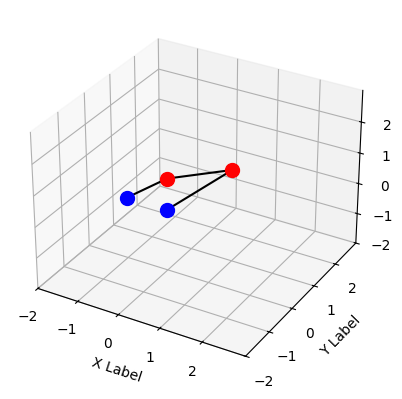

the number of contacts is 0
the number of contacts where hydrophobic interactions can take place is 1


In [277]:
    x = post_processing(coordinates)
    print(x)
    ploting_points(x,bead_types)
    print(f'the number of contacts is {calculate_overlap(x)}')
    #print(f'the number of contacts where hydrophobic interactions can take place is {count_contacts(x,bead_types)}')
    print(f'the number of contacts where hydrophobic interactions can take place is {count_contacts(x,bead_types)}')

In [86]:
print(op)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIII',

In [89]:
import pickle

# Save variables to a .pkl file
data = {"my_variable": op}

with open("data_bead_HPPH.pkl", "wb") as f:
    pickle.dump(data, f)

FileNotFoundError: [Errno 2] No such file or directory: 'data_bead_HHPPHPHPHP(6/8).pkl'

In [15]:
!pip install qiskit-aer --upgrade


## TUTORIALS FOR QISKIT-AER

In [1]:
!pip install qiskit-aer

# Bitstring decoder

In [ ]:
bitstring = '001100001010001100'f
'001100001010001100'
'001100001010001100'

'110011100 001101010 101101000 110100010 000000100 ''

'110011000 001100100 110101000 001010100 110101010 001011010

100 001 100 001 100 001

In [264]:
def convert_to_dict():
    # Define variables
    xia = [0,0,1]
    xib = [1,0,0]
    yia = [0,0,1]
    yib = [0,1,0]
    zia = [1,0,1]
    zib = [0,0,1]
    return {
        'xia': xia,
        'xib': xib,
        'yai': yia,
        'ybi': yib,
        'zai': zia,
        'zbi': zib
    }
result = convert_to_dict()
print(result)

N = 4  
bead_seq = "HPPH"
bead_types = list(bead_seq)


{'xia': [0, 0, 1], 'xib': [1, 0, 0], 'yai': [0, 0, 1], 'ybi': [0, 1, 0], 'zai': [1, 0, 1], 'zbi': [0, 0, 1]}


Coordinates: [(0, 0, 0), (-1, 0, 1), (-1, -1, 1), (0, 0, 1)]


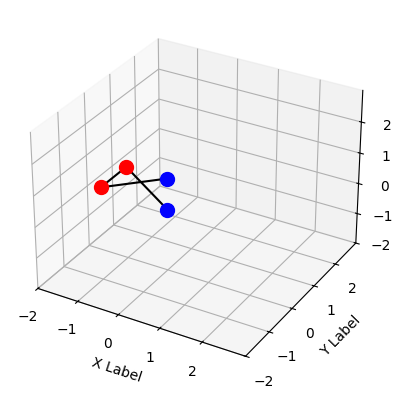

The number of overlaps is 0
The number of contacts is 1


In [265]:
bead_system3 = BeadSystem2(N, bead_types,result)
    
    # Display system details and calculate coordinates
    #bead_system.display()
coordinates = bead_system3.calculate_coordinates()
print("Coordinates:", coordinates)
ploting_points(coordinates, bead_types)
print(f'The number of overlaps is {calculate_overlap(coordinates)}')
print(f'The number of contacts is {count_contacts(coordinates,bead_types)}')

[(-1, 0, 0), (-1, 0, 1), (-1, -1, 1), (0, 0, 0)]


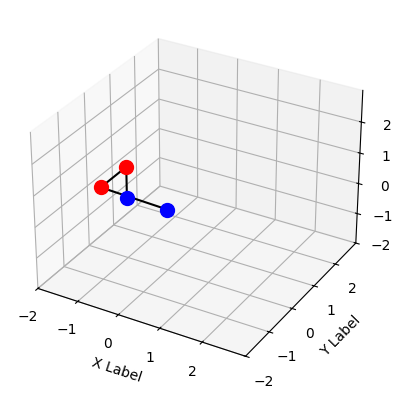

the number of contacts is 0
the number of contacts where hydrophobic interactions can take place is 1


In [263]:
x = post_processing(coordinates)
print(x)
ploting_points(x,bead_types)
print(f'the number of contacts is {calculate_overlap(x)}')
print(f'the number of contacts where hydrophobic interactions can take place is {count_contacts(x,bead_types)}')